In [1]:
import os
import re
import regex
import numpy as np
import pandas as pd
import torch
from sentence_transformers import SentenceTransformer
import umap
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from transformers import pipeline, AutoTokenizer

%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=7

pd.set_option('display.max_colwidth', None)


# Load a pre-trained sentence transformer model
# model = SentenceTransformer("Alibaba-NLP/gte-large-en-v1.5", trust_remote_code=True)
model = SentenceTransformer("all-mpnet-base-v2")

model_llm = "meta-llama/Meta-Llama-3.1-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_llm)
device = 0 if torch.cuda.is_available() else -1

generator = pipeline(
    "text-generation",
    model=model_llm,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device=device,
    do_sample=False,  # No sampling
    temperature=None,  # Not needed when do_sample=False
    top_p=None,        # Not needed when do_sample=False
    pad_token_id=tokenizer.eos_token_id  # Ensure proper padding
)

/ceph/iharsawi/miniconda3/envs/thesis7/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=7


/ceph/iharsawi/miniconda3/envs/thesis7/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [2]:
# Set the folder containing the files
folder_path = "../Llama3_1_Model_2/topicGPT/data/output/FINAL_SUMMARY"

# List of unique ideologies
ideologies = ["ANTI_SJW", "ANTI_THEIST", "BLACK", "CONSPIRACY", "LGBT", "LIBERTARIAN", 
              "MRA", "PARTISAN_RIGHT", "PARTISAN_LEFT", "QANON", "RELIGIOUS_CONSERVATIVE", 
              "SOCIAL_JUSTICE", "SOCIALIST", "WHITE_IDENTITARIAN"]
# ideologies = ["ANTI_SJW"]

def remove_parenthesized_phrases(text):
    # Use regex to find and remove all substrings that start with '(' and end with ')'
    cleaned_text = re.sub(r'\s*\(.*?\)', '', text)
    return cleaned_text.strip()

def doc_label(df, topics_list):
    """
    Add labels to each document based on the topics generated for it.
    - df: dataframe of documents
    - topics_list: list of topics
    """
    pattern = regex.compile("^\[(\d+)\] ([\w\s]+):(.+)")
    all_topics = []
    for line in df["responses"].tolist():
        if type(line) == str:
            line = line.split("\n")
            line_topics = []
            for topic in line:
                if regex.match(pattern, topic):
                    groups = regex.match(pattern, topic).groups()
                    lvl, name, desc = int(groups[0]), groups[1], groups[2]
                    if f"[{lvl}] {name}" in topics_list:
                        line_topics.append(remove_parenthesized_phrases(desc))
                        # line_topics.append(topic)
            line_topics = list(set(line_topics))
            if len(line_topics) > 0:
                all_topics.append(line_topics)
            else:
                all_topics.append(["None"])
        else:
            all_topics.append(["None"])
    return all_topics

# Function to extract main topic and its subtopics dynamically based on a specified topic name
def extract_topic_data_per_ideology_period(file_path, main_topic="Health"):
    try:
        df = pd.read_json(str(file_path), lines=True)
        topics_list = [f"[1] {main_topic}"]
        df["topics"] = doc_label(df, topics_list)
        # Excluding rows with more than one unique topic//"None" ----
        df["num_topics"] = df["topics"].apply(lambda x: len(set(x)))
        df = df[df["topics"].apply(lambda x: x != ["None"])].reset_index(drop=True)

        all_embeddings = []
        concatinated_topics = ""
    
        for index, row in df.iterrows():
            # Step 1: Concatenate all sentences in the 'topics' column for this row
            concatenated_text = ' '.join(row['topics'])  # Join all sentences in the list
            # print("concatenated_text", concatenated_text)
            # Step 2: Generate embedding for the concatenated text
            embedding = model.encode(concatenated_text, convert_to_tensor=True)  # This will be on the GPU (cuda:0)
            all_embeddings.append(embedding.cpu())  # Move to CPU immediately and append to list
            concatinated_topics = concatinated_topics + " - " + concatenated_text
        
        # Step 3: Stack all embeddings and compute the average embedding
        stacked_embeddings = torch.stack(all_embeddings)  # Now all embeddings are on the CPU
        average_embedding = torch.mean(stacked_embeddings, dim=0)  # Compute the mean across all rows

        return {
            "average_embedding": average_embedding,
            "concatinated_topics": concatinated_topics,
            "freq": len(df.index)
        }
    
    except FileNotFoundError:
        print(f"File {file_path} not found.")
        return {}

def generate_text(prompt, max_tokens):
    """
    Generate text using a local model with transformers.
    """
    messages = [
        {"role": "system", "content": "You are equipped with advanced analytical techniques. Your goal is to distill complex information from various topics and summarize the overall subject being discussed in 1 paragraph. Return only the results, without any additional comments."},
        {"role": "user", "content": f"Analyze the following list of topics:\n\n{prompt}"},
    ]
    
    outputs = generator(
        messages,
        max_new_tokens=max_tokens,
    )
    return outputs[0]["generated_text"][-1]["content"]

def generate_graph(main_topic):
    # DataFrame to hold extracted data
    data = []
    
    # Main topic to analyze (can be changed dynamically)
    main_topic = main_topic
    
    # Iterate over unique ideologies and time phases
    for ideology in ideologies:
        for time_phase in ["before", "after"]:  # Check both after and before files
            
            # Construct markdown filename
            filename = f"assignment_{time_phase}_{ideology}.jsonl"
            file_path = os.path.join(folder_path, filename)    

            topic_data = extract_topic_data_per_ideology_period(file_path, main_topic)

            summarized = generate_text(topic_data["concatinated_topics"], 384)

            print("TOPIC: ", main_topic)
            print("IDEOLOGY: ", ideology)
            print("TIME PHASE: ", time_phase)
            print("SUMMARIZED: ", summarized)
            print("\n--------------------------------------------------------------------\n")
            # print(topic_data["concatinated_topics"])

            summarized_embedding = model.encode(summarized, convert_to_tensor=True)  # This will be on the GPU (cuda:0)

            
            # Append the data
            data.append({
                "ideology": ideology,
                "period": time_phase,
                # "embedding": topic_data["average_embedding"].cpu().numpy(),
                "embedding": summarized_embedding.cpu().numpy(),
            })
    
    # Convert data into a DataFrame
    df = pd.DataFrame(data)
    
    # Extract embeddings and labels
    X = np.array(df['embedding'].tolist())  # Embeddings
    y_ideology = df['ideology']  # Ideology
    y_period = df['period']  # Period (before/after)
    
    # Label encode the ideologies for visualization
    le_ideology = LabelEncoder()
    y_ideology_encoded = le_ideology.fit_transform(y_ideology)
    
    # Apply UMAP to project the embeddings into a lower-dimensional space (2D)
    umap_model = umap.UMAP(n_components=2, random_state=42)
    X_umap = umap_model.fit_transform(X)
    
    # Plot the UMAP projection to visualize ideologies with labels
    plt.figure(figsize=(12, 8))
    colors = {'before': 'skyblue', 'after': 'salmon'}
    markers = {'before': 'o', 'after': 's'}
    
    # To track whether we have added a label for each period
    label_added = {'before': False, 'after': False}
    
    for i, (x, y, ideology, period) in enumerate(zip(X_umap[:, 0], X_umap[:, 1], df['ideology'], df['period'])):
        # Add label for the legend only once per period
        if not label_added[period]:
            plt.scatter(x, y, color=colors[period], marker=markers[period], label=f'Period: {period}', alpha=0.7)
            label_added[period] = True
        else:
            plt.scatter(x, y, color=colors[period], marker=markers[period], alpha=0.7)
        
        # Annotate the points with ideology
        plt.annotate(ideology, (x, y), fontsize=9, alpha=0.8)
    
    # Set up the plot details
    plt.title("UMAP Projection of Ideologies (Before and After COVID-19 Outbreak)")
    plt.xlabel("UMAP Component 1")
    plt.ylabel("UMAP Component 2")
    plt.legend(loc='best')  # Legend showing both periods
    plt.grid(True)
    plt.show()
    
    # # Analyze cosine similarity between ideologies before and after COVID
    # similarities = {}
    # for ideology in le_ideology.classes_:
    #     before_emb = X_umap[(df['ideology'] == ideology) & (df['period'] == 'before')]
    #     after_emb = X_umap[(df['ideology'] == ideology) & (df['period'] == 'after')]
        
    #     if before_emb.shape[0] > 0 and after_emb.shape[0] > 0:
    #         # Calculate cosine similarity between embeddings before and after COVID for each ideology
    #         sim = cosine_similarity(before_emb.mean(axis=0).reshape(1, -1), 
    #                                 after_emb.mean(axis=0).reshape(1, -1))[0][0]
    #         similarities[ideology] = sim
    
    # # Output the cosine similarity results
    # print(f"Cosine Similarity between Ideologies Before and After COVID ({main_topic} only):")
    # for ideology, similarity in similarities.items():
    #     print(f"{ideology}: {similarity:.4f}")
    
    # Analyze cosine similarity between ideologies before and after COVID
    similarities = {}
    for ideology in le_ideology.classes_:
        before_emb = X[(df['ideology'] == ideology) & (df['period'] == 'before')]
        after_emb = X[(df['ideology'] == ideology) & (df['period'] == 'after')]
    
        if before_emb.shape[0] > 0 and after_emb.shape[0] > 0:
            # Calculate cosine similarity between embeddings before and after COVID for each ideology
            sim = cosine_similarity(before_emb.mean(axis=0).reshape(1, -1), 
                                    after_emb.mean(axis=0).reshape(1, -1))[0][0]
            similarities[ideology] = sim
    
    # Output the cosine similarity results
    print(f"Cosine Similarity between Ideologies Before and After COVID ({main_topic} only):")
    for ideology, similarity in similarities.items():
        print(f"{ideology}: {similarity:.4f}")
    print("\n--------------------------------------------------------------------\n")

TOPIC:  Politics
IDEOLOGY:  ANTI_SJW
TIME PHASE:  before
SUMMARIZED:  The conversation revolves around a wide range of topics, primarily focusing on politics, social issues, and cultural commentary. The discussion touches on various themes, including the role of government, the impact of social media, and the influence of politics on everyday life. The speakers express their opinions on issues such as gun control, immigration, and the Second Amendment, as well as their views on politicians like President Trump, Alexandria Ocasio-Cortez, and Bernie Sanders. The conversation also delves into social issues like abortion, LGBTQ+ rights, and the #MeToo movement, with some speakers expressing their support for conservative values and others advocating for progressive causes. Additionally, the discussion covers topics like the media's role in shaping public opinion, the impact of cancel culture, and the importance of free speech. Overall, the conversation is a reflection of the current politi

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


TOPIC:  Politics
IDEOLOGY:  LIBERTARIAN
TIME PHASE:  before
SUMMARIZED:  The conversation revolves around various topics, including politics, law enforcement, government policies, and social issues. It touches on the current state of politics, criticizing the UN's approach to climate change, and the controversy surrounding Jordan Peterson's book. The discussion also involves the totalitarian state, the KGB, and the importance of maintaining global leadership. Additionally, it mentions the Democratic Party's internal divisions, President Trump's deregulation efforts, and the Trump administration's actions. The conversation also delves into the First and Fourth Amendment rights, police corruption, and the potential consequences of government debt on the economy. Furthermore, it mentions the hijacking of the gay rights movement, the corporate productization of the movement, and the First Amendment audit. The discussion also involves the effectiveness of nuclear weapons in foreign policy, 

/ceph/iharsawi/miniconda3/envs/thesis7/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


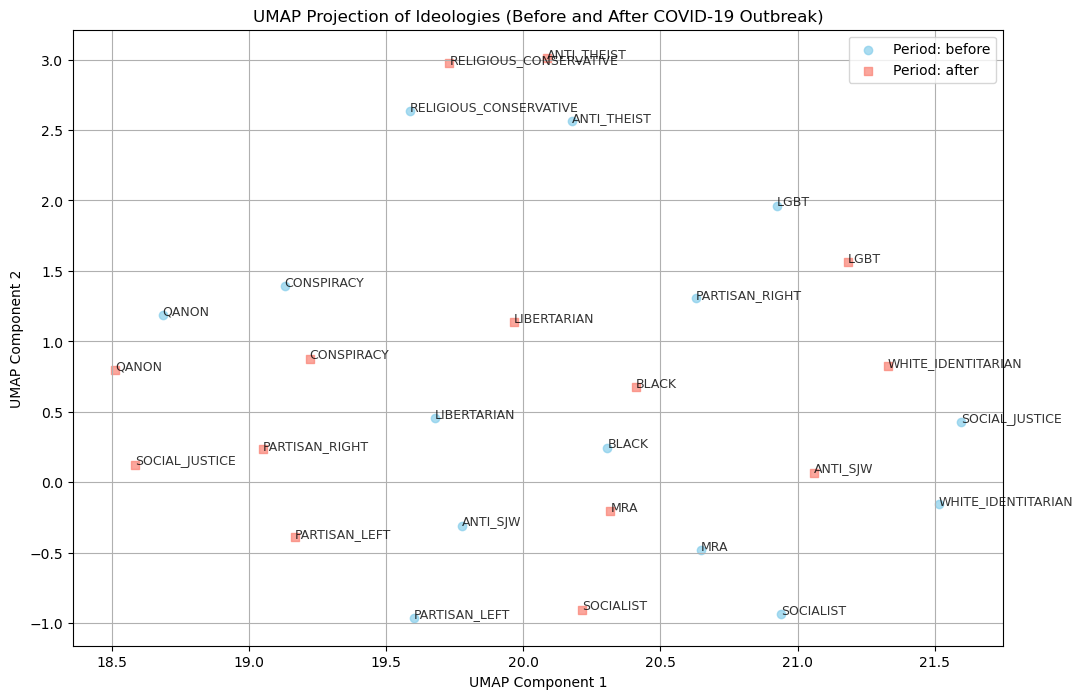

Cosine Similarity between Ideologies Before and After COVID (Politics only):
ANTI_SJW: 0.8094
ANTI_THEIST: 0.7897
BLACK: 0.8153
CONSPIRACY: 0.7620
LGBT: 0.7493
LIBERTARIAN: 0.6638
MRA: 0.8446
PARTISAN_LEFT: 0.8385
PARTISAN_RIGHT: 0.6768
QANON: 0.7941
RELIGIOUS_CONSERVATIVE: 0.7650
SOCIALIST: 0.8231
SOCIAL_JUSTICE: 0.6364
WHITE_IDENTITARIAN: 0.5999

--------------------------------------------------------------------

TOPIC:  Health
IDEOLOGY:  ANTI_SJW
TIME PHASE:  before
SUMMARIZED:  The discussion revolves around various topics, but primarily focuses on health and well-being, encompassing physical and mental aspects. It touches on health-related issues such as obesity, exercise, nutrition, mental health, addiction, and the impact of environmental factors like climate change and social media on overall well-being. Additionally, it explores health-related topics like disease prevention, public health, and access to healthcare, as well as the importance of self-care, regular exercise, an

/ceph/iharsawi/miniconda3/envs/thesis7/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


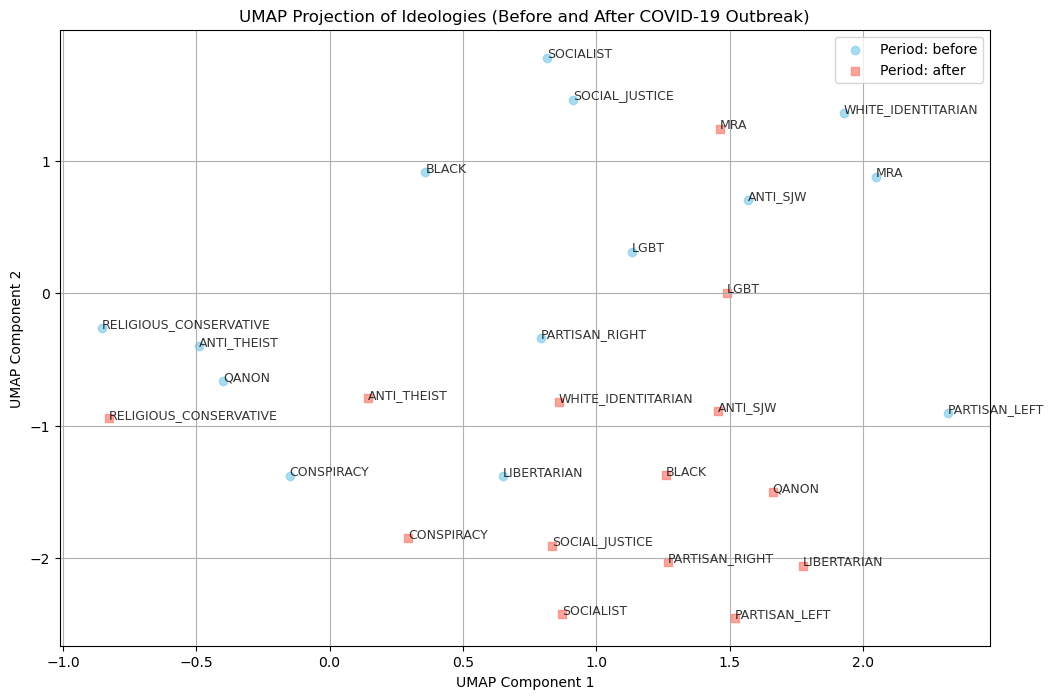

Cosine Similarity between Ideologies Before and After COVID (Health only):
ANTI_SJW: 0.6844
ANTI_THEIST: 0.7378
BLACK: 0.7346
CONSPIRACY: 0.7383
LGBT: 0.8398
LIBERTARIAN: 0.6418
MRA: 0.8254
PARTISAN_LEFT: 0.6295
PARTISAN_RIGHT: 0.4797
QANON: 0.7550
RELIGIOUS_CONSERVATIVE: 0.8840
SOCIALIST: 0.7158
SOCIAL_JUSTICE: 0.6313
WHITE_IDENTITARIAN: 0.6317

--------------------------------------------------------------------

TOPIC:  Human Rights
IDEOLOGY:  ANTI_SJW
TIME PHASE:  before
SUMMARIZED:  The discussion revolves around various human rights issues, including individual liberty, freedom of expression, and the importance of respecting people's identities and choices. The conversation touches on topics such as trans inclusion, sex and gender, and the need for fairness and equality in various aspects of life, including sports, employment, and medical decisions. The discussion also highlights the importance of protecting vulnerable individuals, including children, women, and marginalized grou

/ceph/iharsawi/miniconda3/envs/thesis7/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


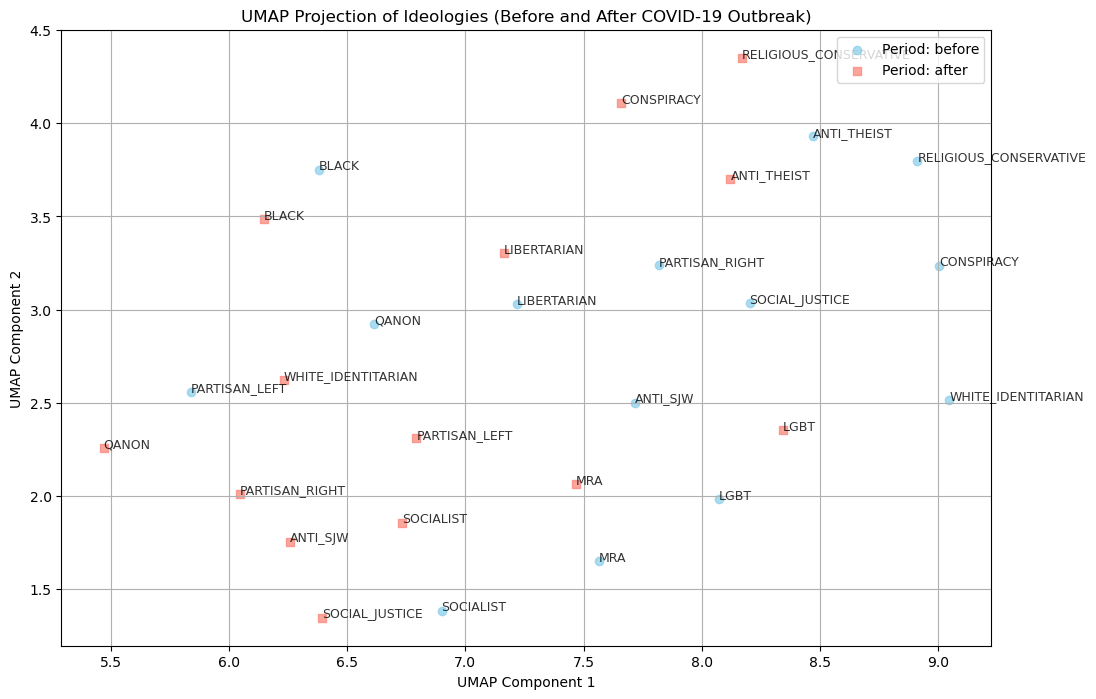

Cosine Similarity between Ideologies Before and After COVID (Human Rights only):
ANTI_SJW: 0.8124
ANTI_THEIST: 0.8696
BLACK: 0.8318
CONSPIRACY: 0.7556
LGBT: 0.8090
LIBERTARIAN: 0.9258
MRA: 0.7804
PARTISAN_LEFT: 0.8240
PARTISAN_RIGHT: 0.7390
QANON: 0.7129
RELIGIOUS_CONSERVATIVE: 0.7783
SOCIALIST: 0.8562
SOCIAL_JUSTICE: 0.8029
WHITE_IDENTITARIAN: 0.6669

--------------------------------------------------------------------

TOPIC:  Media
IDEOLOGY:  ANTI_SJW
TIME PHASE:  before
SUMMARIZED:  The conversation revolves around various topics related to media, including social media, online content, and the portrayal of different issues and groups in the media. The discussion touches on the role of media in shaping public opinion, the impact of media bias, and the ways in which media can influence people's perceptions of reality. The conversation also critiques the media for its handling of certain stories, such as the case of Jussie Smollett, and for its failure to fact-check and correct its r

/ceph/iharsawi/miniconda3/envs/thesis7/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


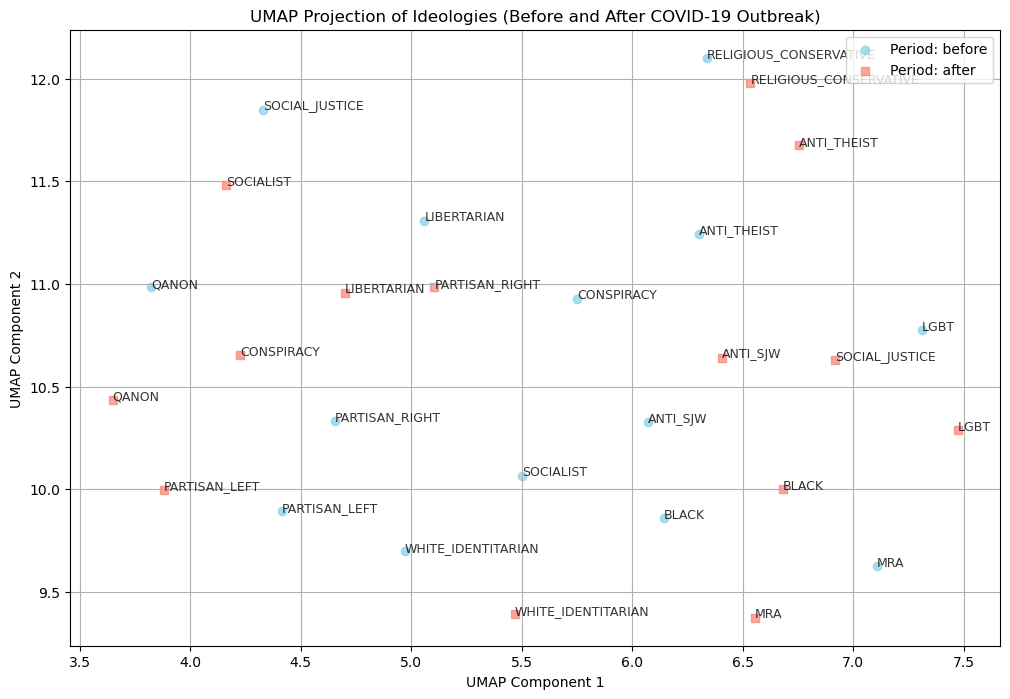

Cosine Similarity between Ideologies Before and After COVID (Media only):
ANTI_SJW: 0.8457
ANTI_THEIST: 0.7901
BLACK: 0.8213
CONSPIRACY: 0.7939
LGBT: 0.7776
LIBERTARIAN: 0.8638
MRA: 0.8638
PARTISAN_LEFT: 0.8823
PARTISAN_RIGHT: 0.8220
QANON: 0.8281
RELIGIOUS_CONSERVATIVE: 0.7782
SOCIALIST: 0.7810
SOCIAL_JUSTICE: 0.7448
WHITE_IDENTITARIAN: 0.8865

--------------------------------------------------------------------

TOPIC:  Government
IDEOLOGY:  ANTI_SJW
TIME PHASE:  before
SUMMARIZED:  The discussion revolves around various government-related topics, including politics, policies, laws, and regulations. The speaker's interest in visiting the Congo could be related to government policies or conservation efforts, and they express support for Bernie Sanders and Tulsi Gabbard, who are politicians. The conversation also touches on issues such as gun control, universal background checks, and licensing systems, which are government-related issues. The speaker mentions the FBI's involvement and 

/ceph/iharsawi/miniconda3/envs/thesis7/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


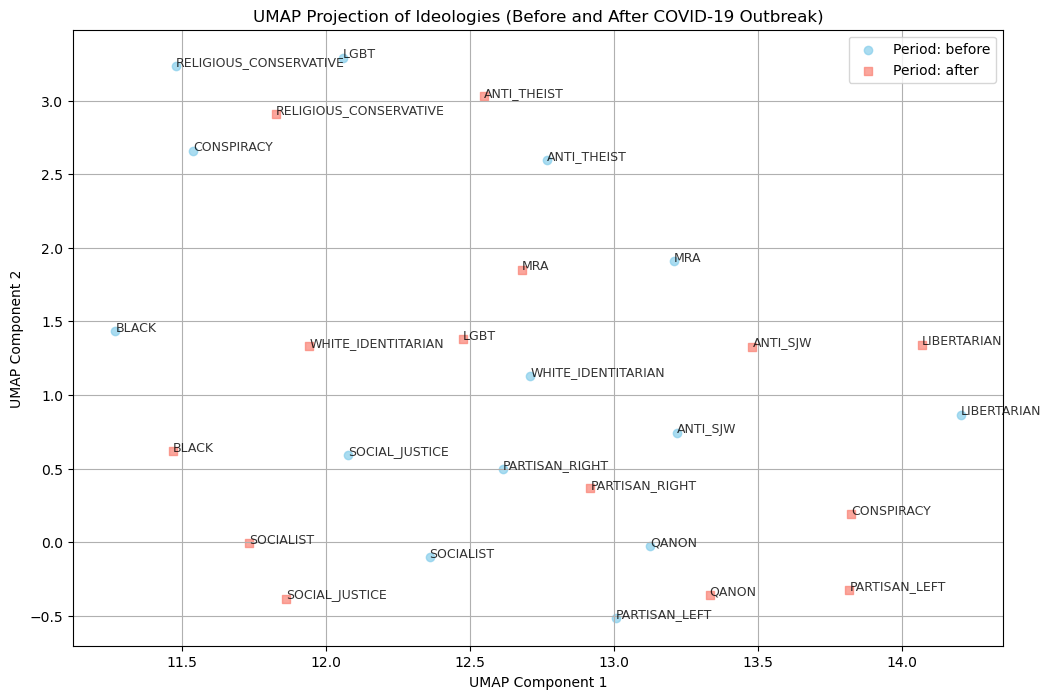

Cosine Similarity between Ideologies Before and After COVID (Government only):
ANTI_SJW: 0.6820
ANTI_THEIST: 0.7478
BLACK: 0.7497
CONSPIRACY: 0.6283
LGBT: 0.5461
LIBERTARIAN: 0.8501
MRA: 0.7530
PARTISAN_LEFT: 0.7218
PARTISAN_RIGHT: 0.7469
QANON: 0.8257
RELIGIOUS_CONSERVATIVE: 0.7809
SOCIALIST: 0.8046
SOCIAL_JUSTICE: 0.7517
WHITE_IDENTITARIAN: 0.7607

--------------------------------------------------------------------

TOPIC:  Community
IDEOLOGY:  ANTI_SJW
TIME PHASE:  before
SUMMARIZED:  The topics discussed revolve around various aspects of community, including social issues, community events, and the impact of individual actions on the community. The conversations touch on topics such as trans inclusion, gun control, poverty, homelessness, and the importance of community involvement and collective action. The discussions also highlight the need for education, awareness, and understanding of different perspectives and experiences within the community. Additionally, the topics of comm

/ceph/iharsawi/miniconda3/envs/thesis7/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


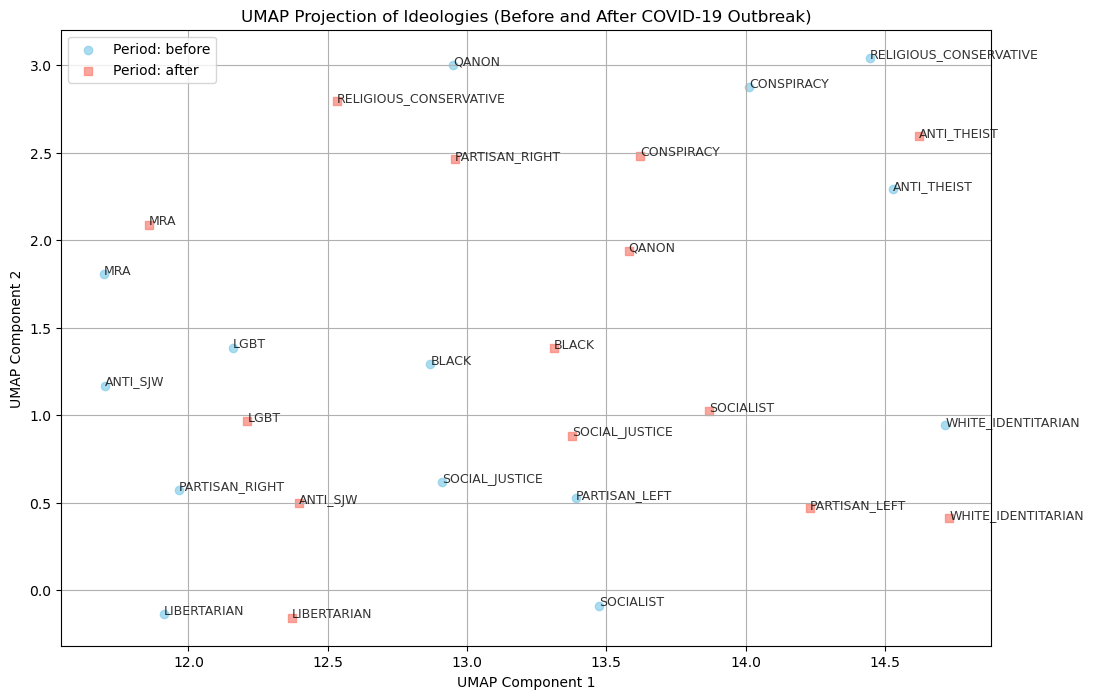

Cosine Similarity between Ideologies Before and After COVID (Community only):
ANTI_SJW: 0.8155
ANTI_THEIST: 0.8294
BLACK: 0.8809
CONSPIRACY: 0.7357
LGBT: 0.8240
LIBERTARIAN: 0.8669
MRA: 0.8158
PARTISAN_LEFT: 0.7163
PARTISAN_RIGHT: 0.7161
QANON: 0.7778
RELIGIOUS_CONSERVATIVE: 0.7222
SOCIALIST: 0.8326
SOCIAL_JUSTICE: 0.8283
WHITE_IDENTITARIAN: 0.8523

--------------------------------------------------------------------

TOPIC:  Identity
IDEOLOGY:  ANTI_SJW
TIME PHASE:  before
SUMMARIZED:  The discussion revolves around the complex and multifaceted concept of identity, encompassing various aspects such as sex, gender, ancestry, ethnicity, and personal characteristics. The conversation touches on the importance of respecting and acknowledging individual identities, including those of marginalized groups like trans women, black people, and women. It also delves into the complexities of identity politics, the impact of societal norms and expectations on individuals, and the need for open and

/ceph/iharsawi/miniconda3/envs/thesis7/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


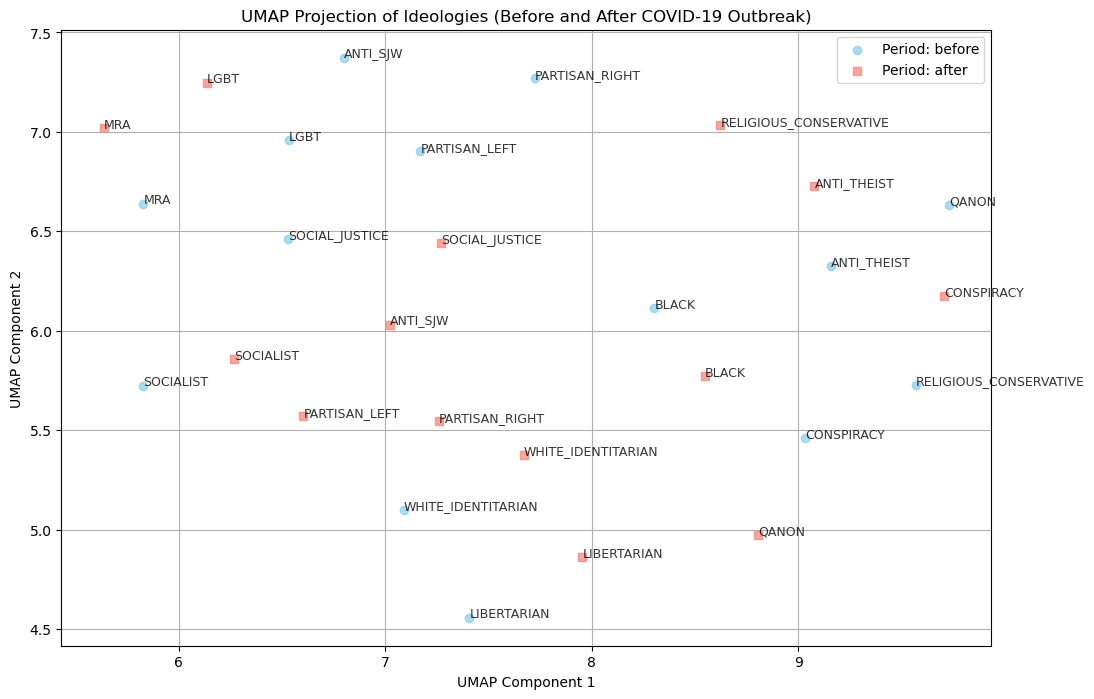

Cosine Similarity between Ideologies Before and After COVID (Identity only):
ANTI_SJW: 0.8307
ANTI_THEIST: 0.7821
BLACK: 0.8333
CONSPIRACY: 0.8350
LGBT: 0.7560
LIBERTARIAN: 0.7870
MRA: 0.7352
PARTISAN_LEFT: 0.8144
PARTISAN_RIGHT: 0.8055
QANON: 0.6585
RELIGIOUS_CONSERVATIVE: 0.8323
SOCIALIST: 0.8493
SOCIAL_JUSTICE: 0.8897
WHITE_IDENTITARIAN: 0.7284

--------------------------------------------------------------------

TOPIC:  Social Justice
IDEOLOGY:  ANTI_SJW
TIME PHASE:  before
SUMMARIZED:  The discussion revolves around various social justice issues, including the pay gap between men and women, trans inclusion, gun control, climate change, systemic discrimination, and racism. The conversation touches on topics such as the challenges of implementing social justice, the importance of considering biological differences in sports, the need to address the root causes of unemployment, and the impact of social media on mental health. The discussion also critiques the Democratic Party's focu

/ceph/iharsawi/miniconda3/envs/thesis7/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


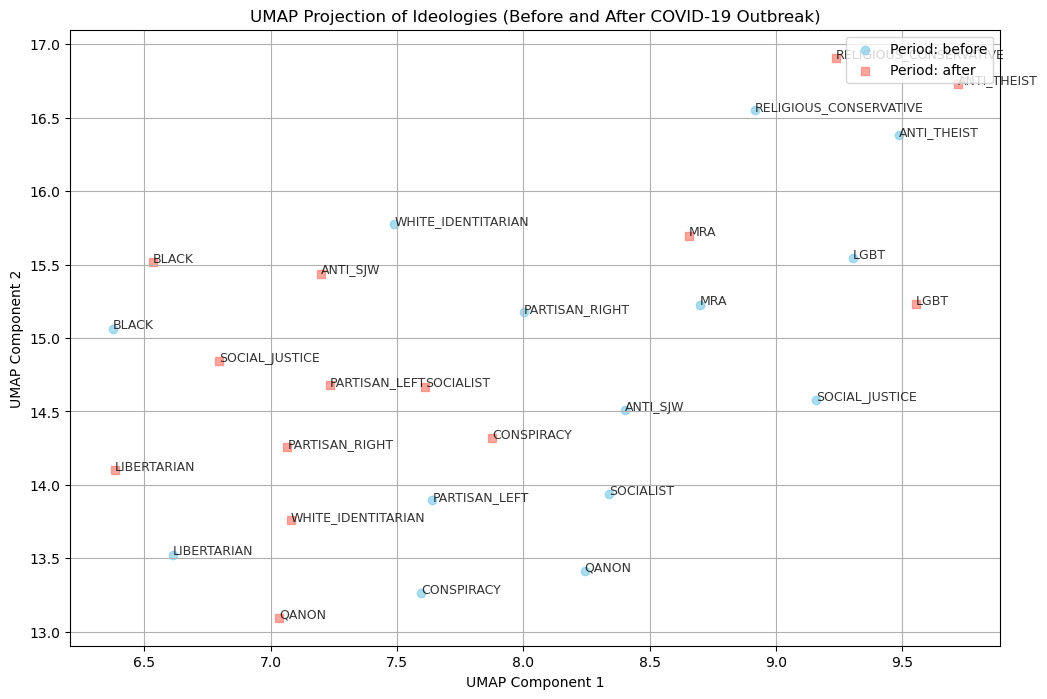

Cosine Similarity between Ideologies Before and After COVID (Social Justice only):
ANTI_SJW: 0.7700
ANTI_THEIST: 0.8422
BLACK: 0.8140
CONSPIRACY: 0.7908
LGBT: 0.7951
LIBERTARIAN: 0.8428
MRA: 0.8209
PARTISAN_LEFT: 0.8058
PARTISAN_RIGHT: 0.7714
QANON: 0.7914
RELIGIOUS_CONSERVATIVE: 0.8555
SOCIALIST: 0.6612
SOCIAL_JUSTICE: 0.8586
WHITE_IDENTITARIAN: 0.7259

--------------------------------------------------------------------

TOPIC:  Culture
IDEOLOGY:  ANTI_SJW
TIME PHASE:  before
SUMMARIZED:  The discussion revolves around various cultural topics, including the representation of women in comedy, the impact of social justice movements on society, and the intersection of culture and history. The conversation touches on the portrayal of strong female characters in movies and video games, the critique of woke culture in the Marvel Cinematic Universe, and the blending of traditional and modern elements in art and media. Additionally, the discussion explores the cultural significance of fame, 

/ceph/iharsawi/miniconda3/envs/thesis7/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


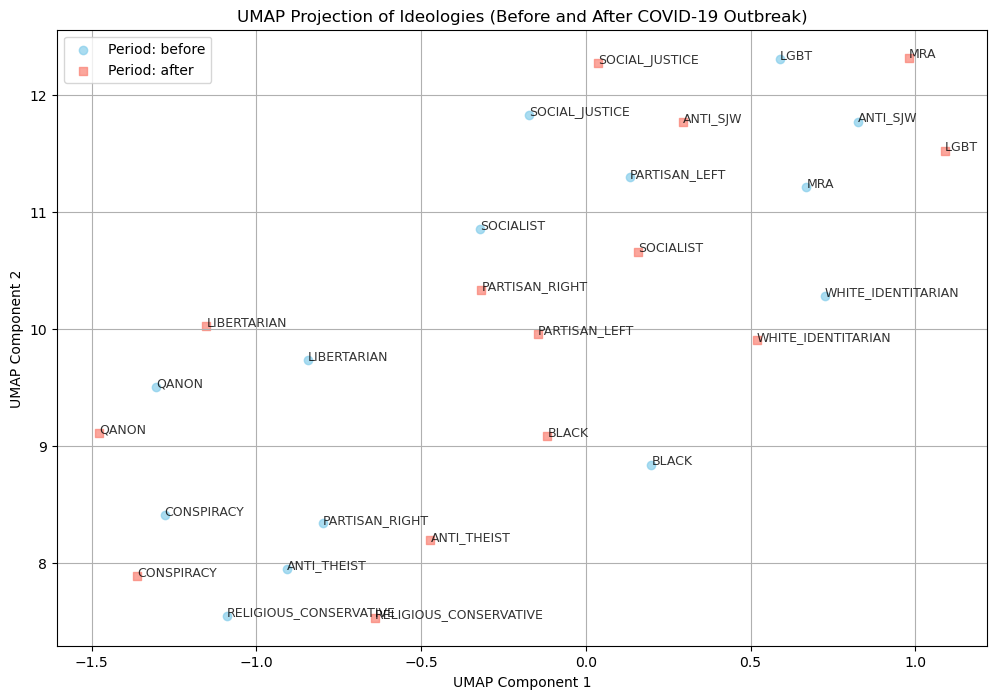

Cosine Similarity between Ideologies Before and After COVID (Culture only):
ANTI_SJW: 0.7284
ANTI_THEIST: 0.6759
BLACK: 0.8385
CONSPIRACY: 0.7508
LGBT: 0.5447
LIBERTARIAN: 0.7138
MRA: 0.7433
PARTISAN_LEFT: 0.6850
PARTISAN_RIGHT: 0.5377
QANON: 0.7400
RELIGIOUS_CONSERVATIVE: 0.8048
SOCIALIST: 0.7039
SOCIAL_JUSTICE: 0.7553
WHITE_IDENTITARIAN: 0.6904

--------------------------------------------------------------------

TOPIC:  Human Behavior
IDEOLOGY:  ANTI_SJW
TIME PHASE:  before
SUMMARIZED:  The topics discussed revolve around human behavior, encompassing various aspects of life, including relationships, interactions, emotions, and decision-making. The conversations delve into the complexities of human nature, exploring how people perceive and interact with solitude, their understanding of sex and gender, and how these factors influence their behavior and relationships. The discussions also touch on the impact of external influences, such as societal norms, media, and technology, on hum

/ceph/iharsawi/miniconda3/envs/thesis7/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


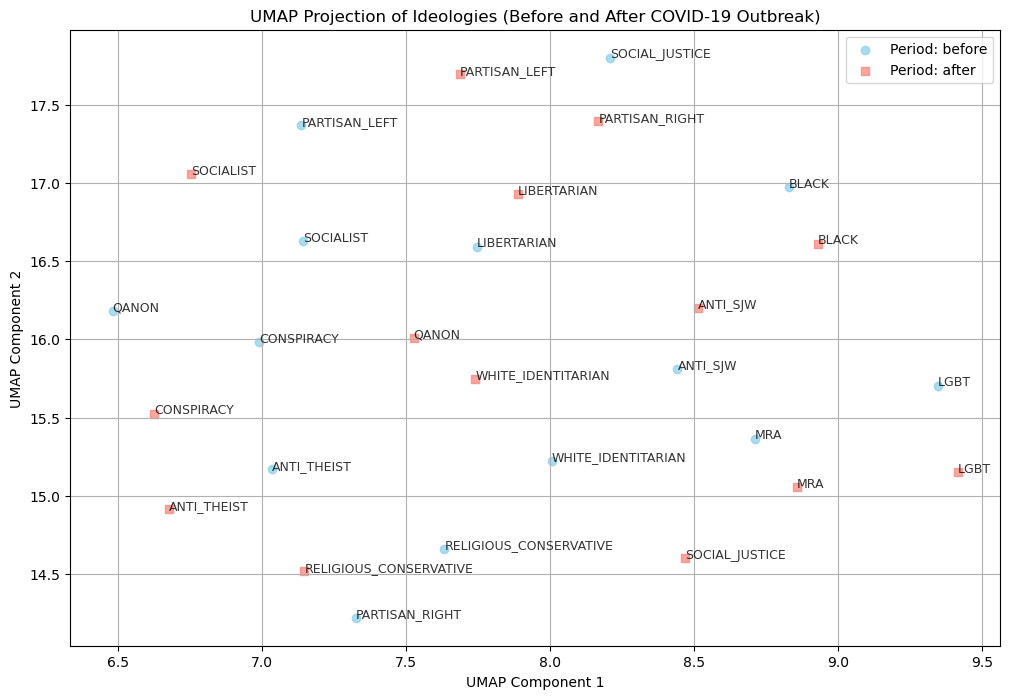

Cosine Similarity between Ideologies Before and After COVID (Human Behavior only):
ANTI_SJW: 0.8325
ANTI_THEIST: 0.7421
BLACK: 0.7050
CONSPIRACY: 0.7055
LGBT: 0.7263
LIBERTARIAN: 0.7562
MRA: 0.7573
PARTISAN_LEFT: 0.7615
PARTISAN_RIGHT: 0.6027
QANON: 0.7161
RELIGIOUS_CONSERVATIVE: 0.8651
SOCIALIST: 0.8401
SOCIAL_JUSTICE: 0.6480
WHITE_IDENTITARIAN: 0.6151

--------------------------------------------------------------------

TOPIC:  Education
IDEOLOGY:  ANTI_SJW
TIME PHASE:  before
SUMMARIZED:  The discussion revolves around various topics, but a common thread is the importance of education, awareness, and critical thinking in shaping perspectives and making informed decisions. This is evident in the speaker's emphasis on scientific facts, the need for proper education on complex concepts like gender identity, and the importance of learning from others and being willing to change one's perspective. The topics of gun control, medical innovation, and social justice are also discussed in th

/ceph/iharsawi/miniconda3/envs/thesis7/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


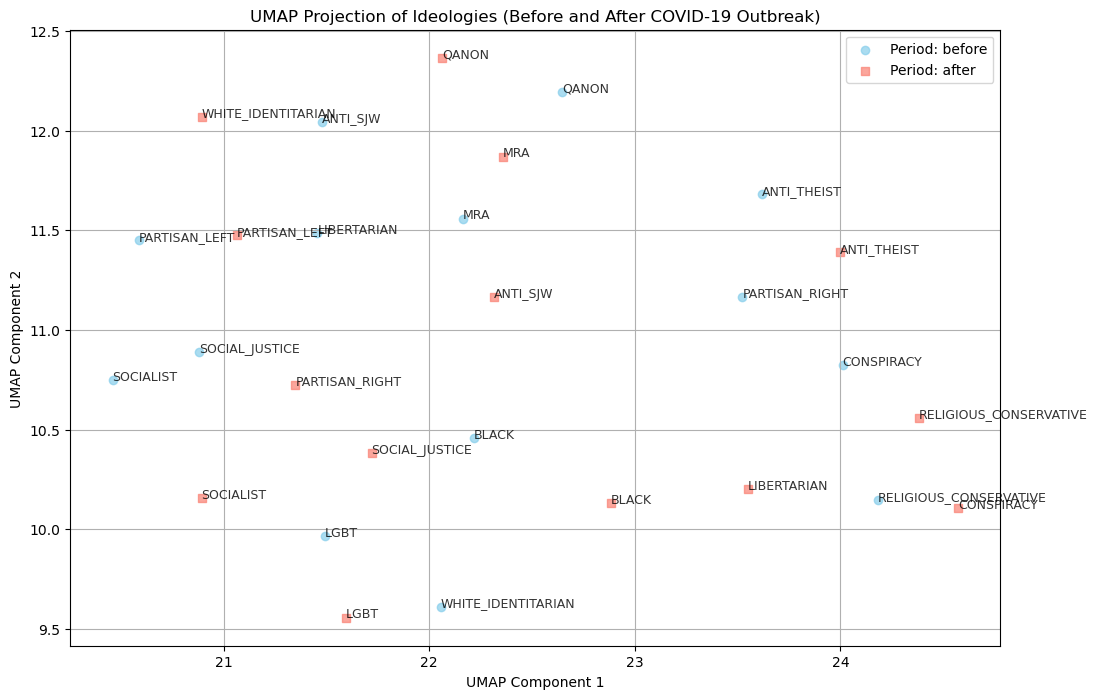

Cosine Similarity between Ideologies Before and After COVID (Education only):
ANTI_SJW: 0.7303
ANTI_THEIST: 0.8204
BLACK: 0.7908
CONSPIRACY: 0.7226
LGBT: 0.6460
LIBERTARIAN: 0.6304
MRA: 0.7566
PARTISAN_LEFT: 0.8328
PARTISAN_RIGHT: 0.7031
QANON: 0.6815
RELIGIOUS_CONSERVATIVE: 0.7626
SOCIALIST: 0.7436
SOCIAL_JUSTICE: 0.6796
WHITE_IDENTITARIAN: 0.6173

--------------------------------------------------------------------

TOPIC:  Relationships
IDEOLOGY:  ANTI_SJW
TIME PHASE:  before
SUMMARIZED:  The conversation revolves around various aspects of relationships, including romantic relationships, friendships, family relationships, and professional relationships. The discussion touches on topics such as the importance of honesty and respect in relationships, the impact of societal attitudes on relationships, and the need to promote healthy relationships and body image. The conversation also delves into specific relationships, such as the relationships between men and women, the relationships 

/ceph/iharsawi/miniconda3/envs/thesis7/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


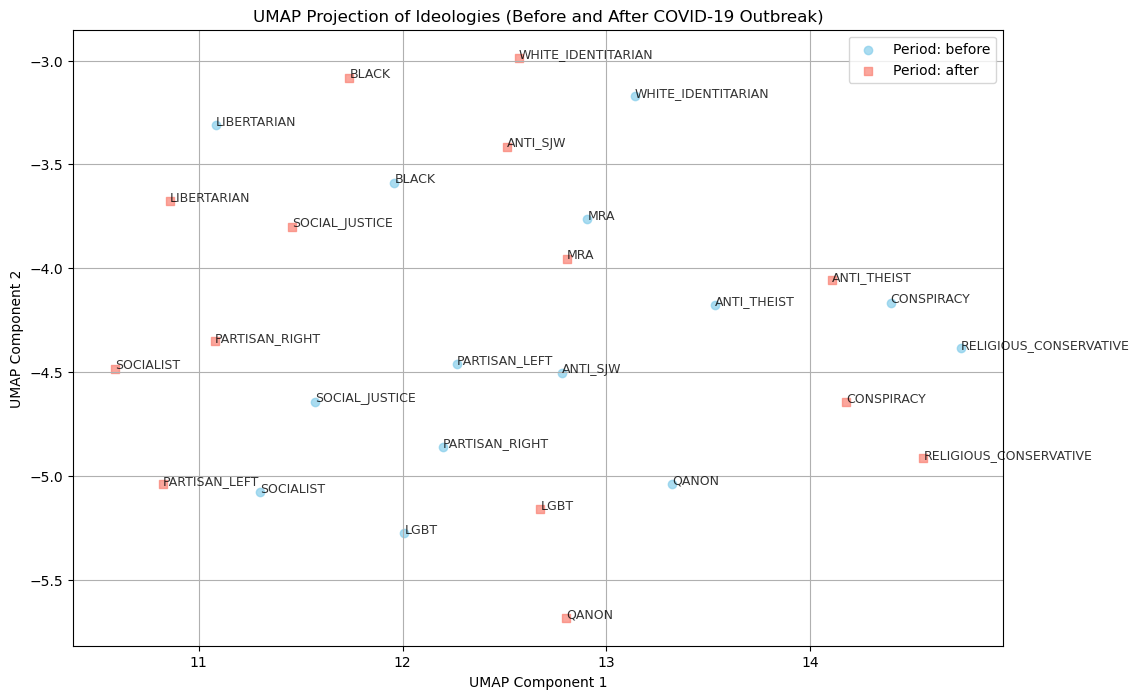

Cosine Similarity between Ideologies Before and After COVID (Relationships only):
ANTI_SJW: 0.8334
ANTI_THEIST: 0.9038
BLACK: 0.9085
CONSPIRACY: 0.9237
LGBT: 0.7471
LIBERTARIAN: 0.8730
MRA: 0.8236
PARTISAN_LEFT: 0.7752
PARTISAN_RIGHT: 0.6801
QANON: 0.8516
RELIGIOUS_CONSERVATIVE: 0.8281
SOCIALIST: 0.7754
SOCIAL_JUSTICE: 0.7741
WHITE_IDENTITARIAN: 0.8255

--------------------------------------------------------------------

TOPIC:  Personal Growth
IDEOLOGY:  ANTI_SJW
TIME PHASE:  before
SUMMARIZED:  The topics discussed in the given list revolve around personal growth, self-improvement, and self-awareness. Many of the conversations touch on the importance of introspection, creativity, and challenging oneself to become a better person. The list highlights various aspects of personal growth, including the need to prioritize one's safety and well-being, the importance of learning from mistakes, and the value of self-expression and identity. Additionally, several discussions emphasize the ne

/ceph/iharsawi/miniconda3/envs/thesis7/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


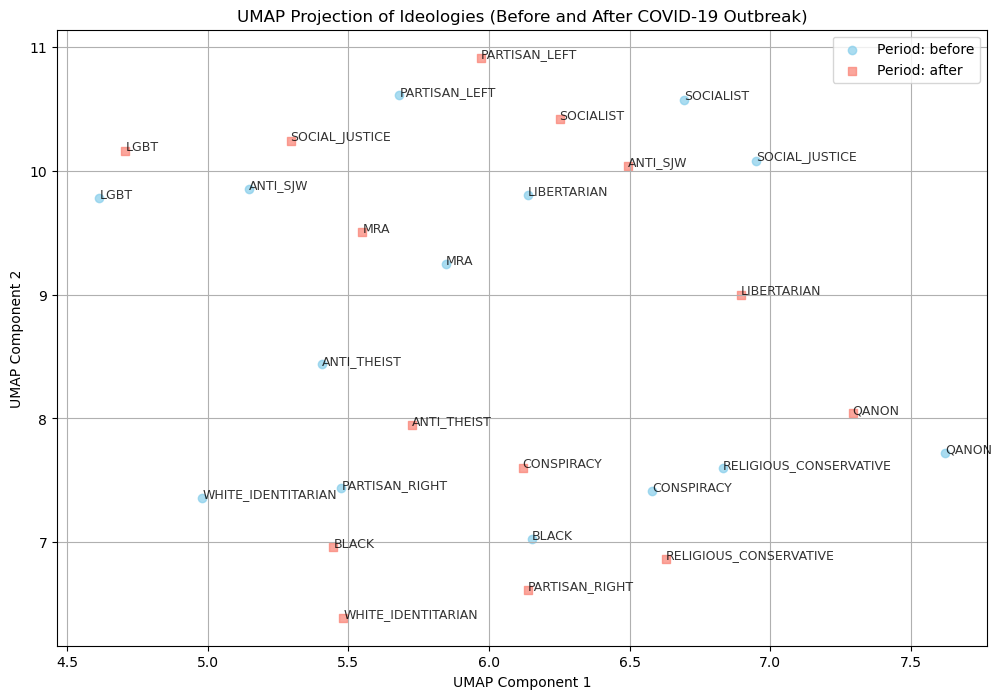

Cosine Similarity between Ideologies Before and After COVID (Personal Growth only):
ANTI_SJW: 0.9329
ANTI_THEIST: 0.8972
BLACK: 0.9519
CONSPIRACY: 0.8944
LGBT: 0.8494
LIBERTARIAN: 0.8434
MRA: 0.9210
PARTISAN_LEFT: 0.8924
PARTISAN_RIGHT: 0.9296
QANON: 0.8459
RELIGIOUS_CONSERVATIVE: 0.8193
SOCIALIST: 0.8334
SOCIAL_JUSTICE: 0.8707
WHITE_IDENTITARIAN: 0.8687

--------------------------------------------------------------------

TOPIC:  Society
IDEOLOGY:  ANTI_SJW
TIME PHASE:  before
SUMMARIZED:  The conversation touches on various societal issues, including the pay gap between men and women, the impact of changing the definition of sex on society, the debate over trans inclusion, the consequences of fake news on individuals' livelihoods, the importance of safety and protection in various environments, the public's perception of the media, and the need for a more nuanced understanding of biological differences between men and women. The discussion also delves into the culture war, division,

/ceph/iharsawi/miniconda3/envs/thesis7/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


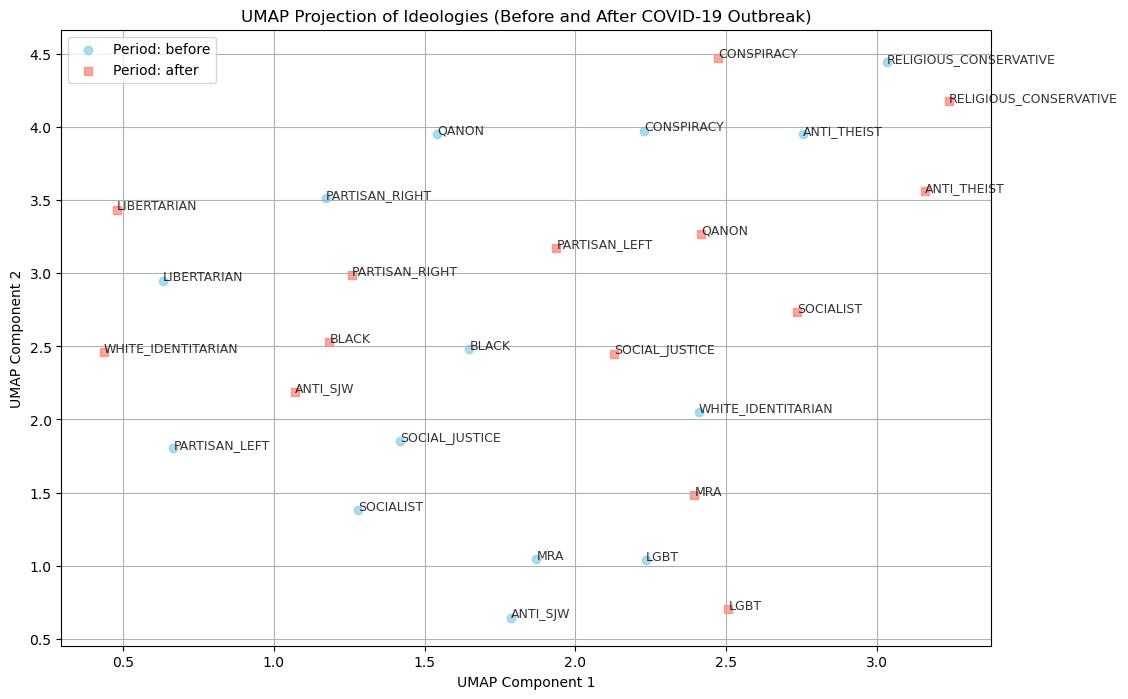

Cosine Similarity between Ideologies Before and After COVID (Society only):
ANTI_SJW: 0.6520
ANTI_THEIST: 0.8305
BLACK: 0.8636
CONSPIRACY: 0.7802
LGBT: 0.6707
LIBERTARIAN: 0.8842
MRA: 0.8241
PARTISAN_LEFT: 0.7701
PARTISAN_RIGHT: 0.7687
QANON: 0.7662
RELIGIOUS_CONSERVATIVE: 0.7024
SOCIALIST: 0.7815
SOCIAL_JUSTICE: 0.7277
WHITE_IDENTITARIAN: 0.6279

--------------------------------------------------------------------

TOPIC:  Economy
IDEOLOGY:  ANTI_SJW
TIME PHASE:  before
SUMMARIZED:  The discussion revolves around various economic considerations, including the impact of government policies, market trends, and technological advancements on the economy. The topics range from the price and availability of consumer goods, such as pistols and Peloton bikes, to the potential consequences of automation, national gun registries, and tax policies on employment and economic growth. Additionally, the conversation touches on the economic implications of social issues, such as income inequality and

/ceph/iharsawi/miniconda3/envs/thesis7/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


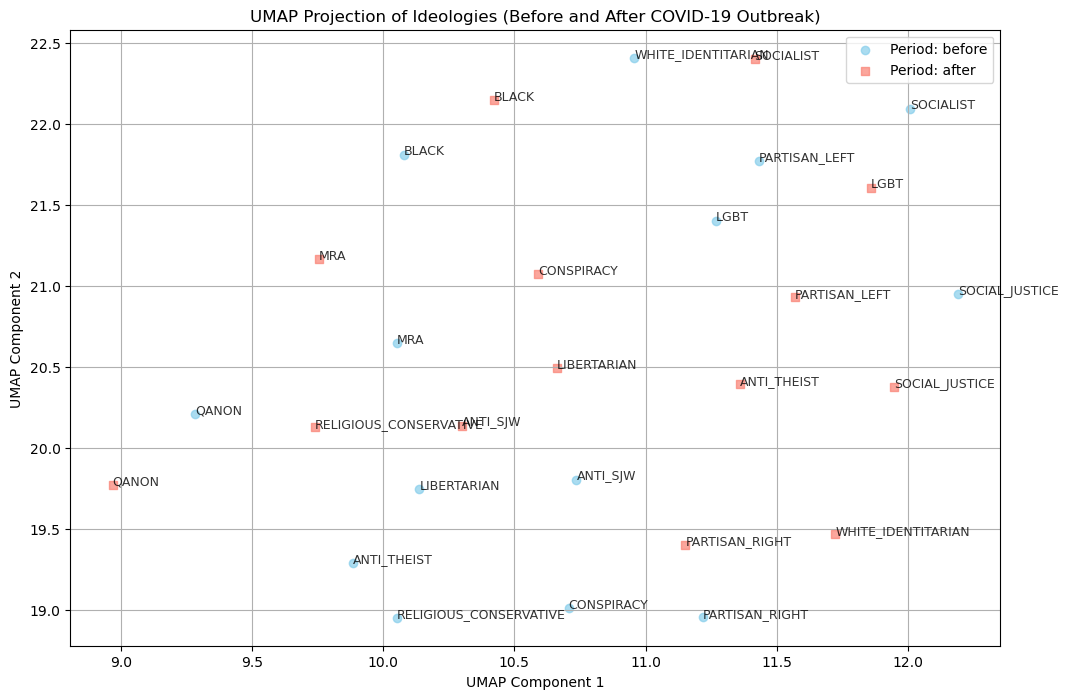

Cosine Similarity between Ideologies Before and After COVID (Economy only):
ANTI_SJW: 0.4170
ANTI_THEIST: 0.2968
BLACK: 0.8120
CONSPIRACY: 0.6127
LGBT: 0.4642
LIBERTARIAN: 0.7782
MRA: 0.6073
PARTISAN_LEFT: 0.7691
PARTISAN_RIGHT: 0.7129
QANON: 0.7963
RELIGIOUS_CONSERVATIVE: 0.5025
SOCIALIST: 0.7082
SOCIAL_JUSTICE: 0.7854
WHITE_IDENTITARIAN: 0.4123

--------------------------------------------------------------------

TOPIC:  Law Enforcement
IDEOLOGY:  ANTI_SJW
TIME PHASE:  before
SUMMARIZED:  The topics discussed in the provided list revolve around various issues, including law enforcement, government policies, and social justice. The majority of the topics are related to law enforcement, with discussions on police presence during riots, entrapment, harassment, and the need for safety and protection. Other topics include government policies, such as gun control laws, the Second Amendment, and the potential for a national gun registry. Social justice issues, such as racism, sexism, and h

/ceph/iharsawi/miniconda3/envs/thesis7/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


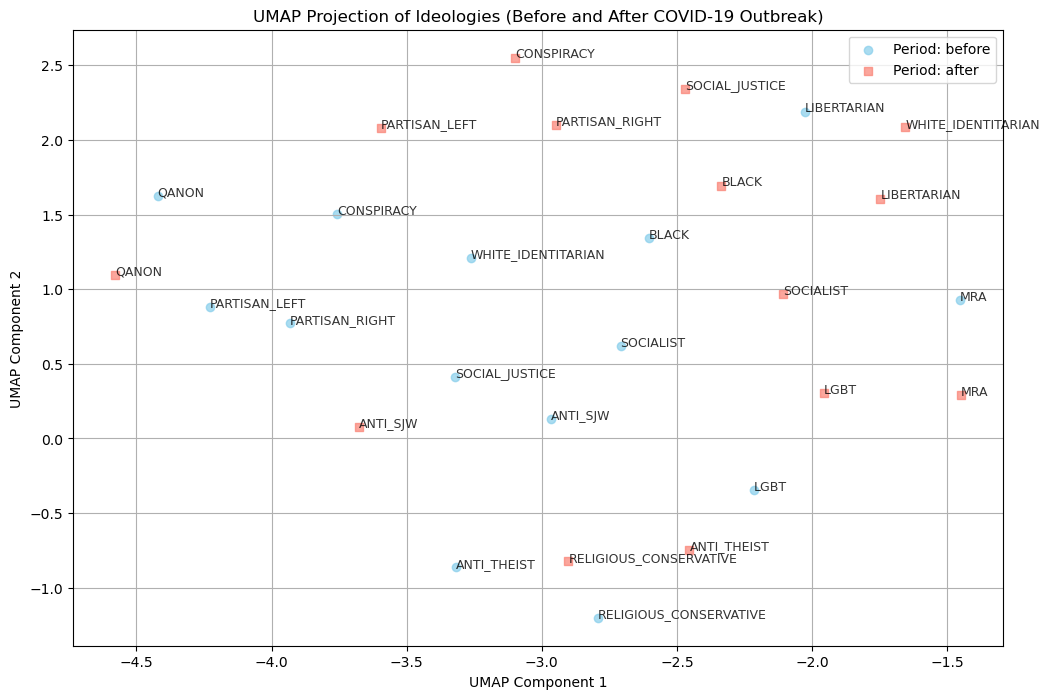

Cosine Similarity between Ideologies Before and After COVID (Law Enforcement only):
ANTI_SJW: 0.7956
ANTI_THEIST: 0.6667
BLACK: 0.8817
CONSPIRACY: 0.7896
LGBT: 0.6002
LIBERTARIAN: 0.8883
MRA: 0.8301
PARTISAN_LEFT: 0.8282
PARTISAN_RIGHT: 0.7934
QANON: 0.8481
RELIGIOUS_CONSERVATIVE: 0.7891
SOCIALIST: 0.7720
SOCIAL_JUSTICE: 0.7249
WHITE_IDENTITARIAN: 0.7250

--------------------------------------------------------------------

TOPIC:  Social Commentary
IDEOLOGY:  ANTI_SJW
TIME PHASE:  before
SUMMARIZED:  The topics discussed in the given list revolve around various social issues, including the negative effects of loneliness, the importance of treating people with respect and kindness, the impact of DNA ancestry tests on people's lives, the controversy surrounding social justice, the critique of Onision's behavior, the debate on gun control, the discussion on the Electoral College system, the criticism of the Democratic Party's focus on identity politics, the ongoing presence of Antifa on 

/ceph/iharsawi/miniconda3/envs/thesis7/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


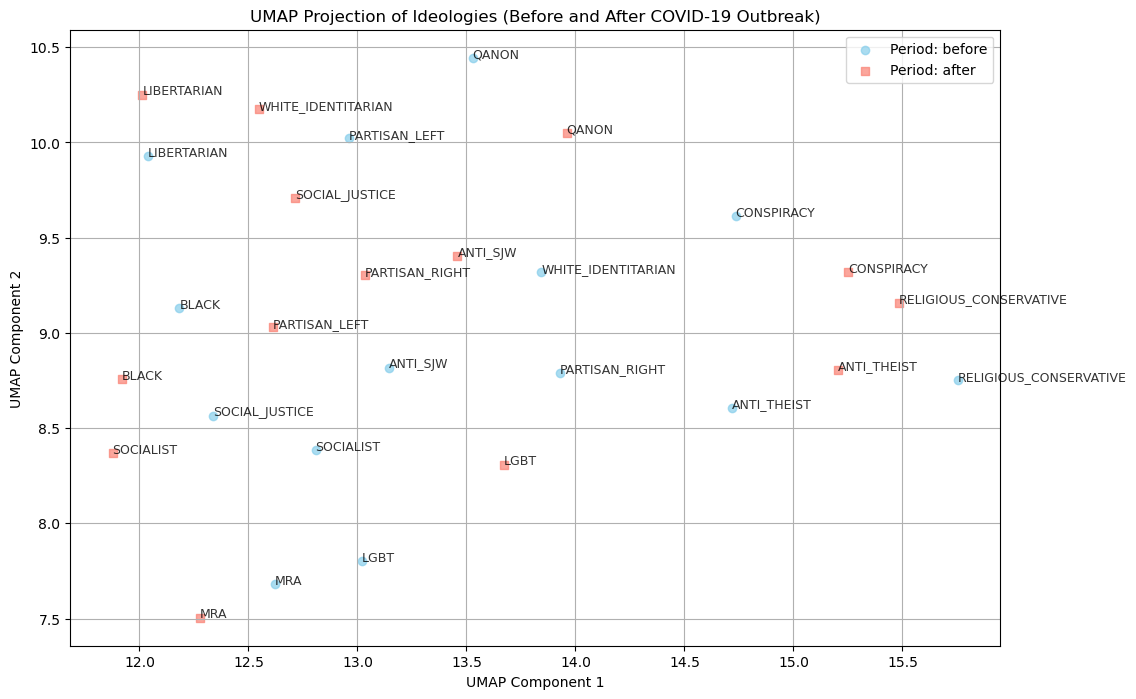

Cosine Similarity between Ideologies Before and After COVID (Social Commentary only):
ANTI_SJW: 0.7398
ANTI_THEIST: 0.7915
BLACK: 0.6918
CONSPIRACY: 0.7072
LGBT: 0.6171
LIBERTARIAN: 0.8906
MRA: 0.7843
PARTISAN_LEFT: 0.7488
PARTISAN_RIGHT: 0.7664
QANON: 0.6508
RELIGIOUS_CONSERVATIVE: 0.7118
SOCIALIST: 0.7990
SOCIAL_JUSTICE: 0.7939
WHITE_IDENTITARIAN: 0.6365

--------------------------------------------------------------------

TOPIC:  Faith
IDEOLOGY:  ANTI_SJW
TIME PHASE:  before
SUMMARIZED:  The conversation revolves around various topics, including faith, values, and spirituality, drawing from multiple world religions such as Buddhism, Christianity, Judaism, and Islam. The discussion touches on the role of faith in shaping perspectives on social issues like abortion, climate change, and social justice, as well as the importance of moral authority and personal values. The conversation also references quotes from influential figures such as the Buddha, Lao Tzu, Epictetus, and Kurt Cobai

/ceph/iharsawi/miniconda3/envs/thesis7/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


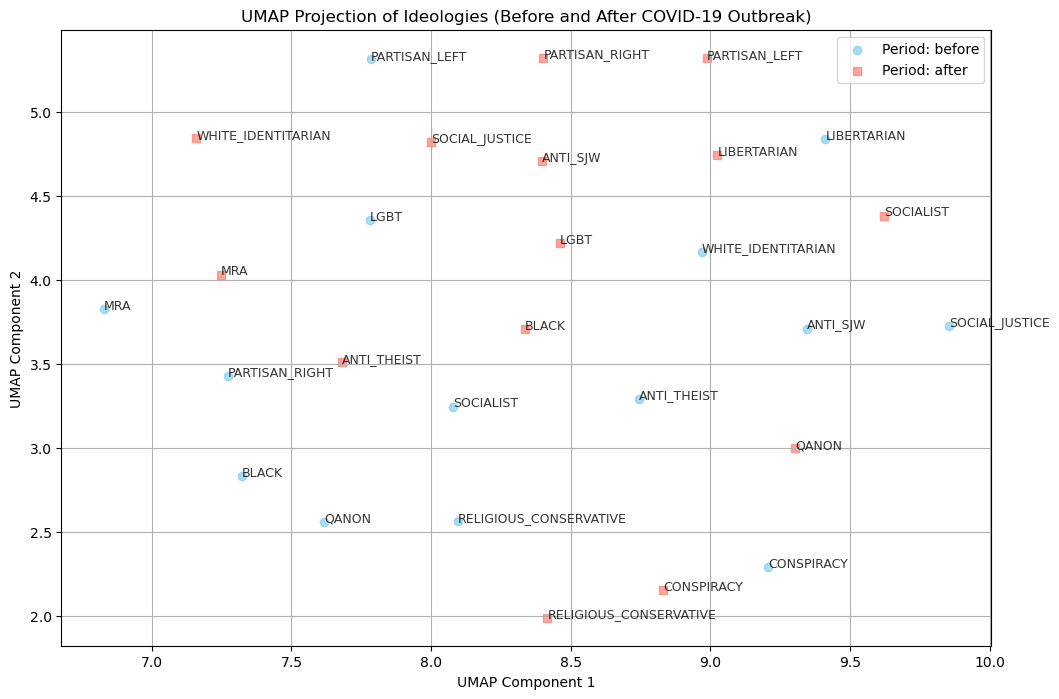

Cosine Similarity between Ideologies Before and After COVID (Faith only):
ANTI_SJW: 0.8052
ANTI_THEIST: 0.8927
BLACK: 0.9491
CONSPIRACY: 0.8033
LGBT: 0.7223
LIBERTARIAN: 0.7022
MRA: 0.7817
PARTISAN_LEFT: 0.7116
PARTISAN_RIGHT: 0.7856
QANON: 0.7135
RELIGIOUS_CONSERVATIVE: 0.8124
SOCIALIST: 0.8507
SOCIAL_JUSTICE: 0.6607
WHITE_IDENTITARIAN: 0.7854

--------------------------------------------------------------------

TOPIC:  Leadership
IDEOLOGY:  ANTI_SJW
TIME PHASE:  before
SUMMARIZED:  The discussion revolves around various topics, but a common thread is the concept of leadership, which is explored through different lenses, including politics, social issues, personal responsibility, and decision-making. The analysis highlights the importance of nuanced approaches, compassion, and empathy in leadership, as well as the need for accountability and fairness. The discussion also touches on the role of leaders in shaping societal norms, promoting positive change, and addressing complex issues

/ceph/iharsawi/miniconda3/envs/thesis7/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


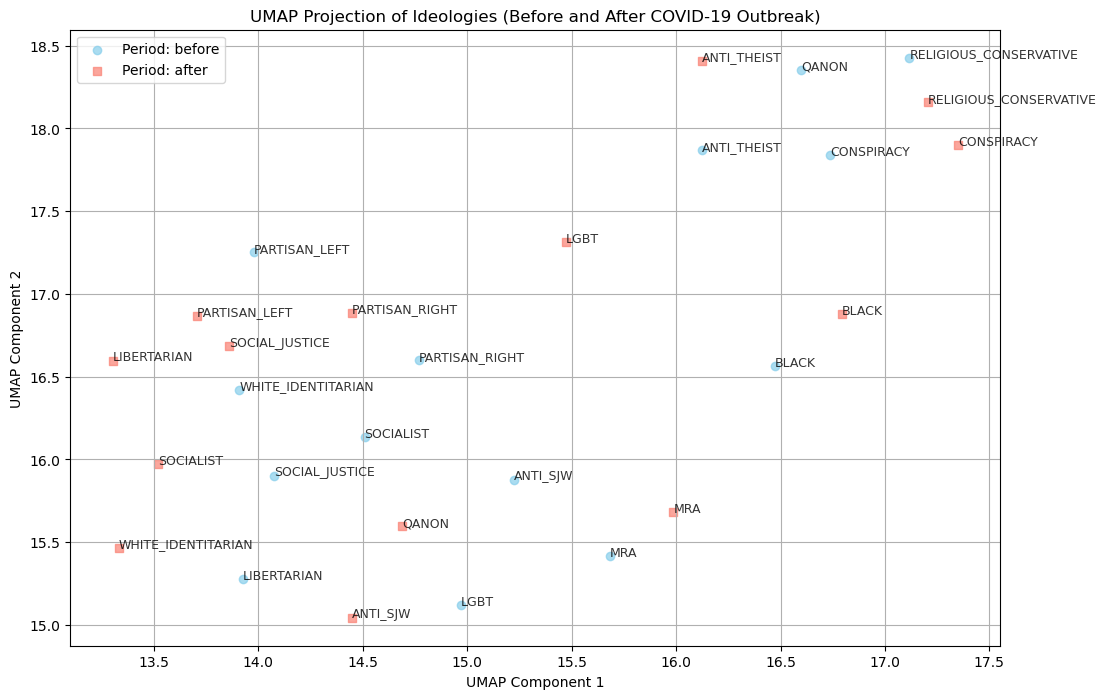

Cosine Similarity between Ideologies Before and After COVID (Leadership only):
ANTI_SJW: 0.8413
ANTI_THEIST: 0.7732
BLACK: 0.8794
CONSPIRACY: 0.7699
LGBT: 0.4806
LIBERTARIAN: 0.6868
MRA: 0.7506
PARTISAN_LEFT: 0.8640
PARTISAN_RIGHT: 0.8021
QANON: 0.7131
RELIGIOUS_CONSERVATIVE: 0.8398
SOCIALIST: 0.8047
SOCIAL_JUSTICE: 0.8593
WHITE_IDENTITARIAN: 0.6646

--------------------------------------------------------------------

TOPIC:  History
IDEOLOGY:  ANTI_SJW
TIME PHASE:  before
SUMMARIZED:  The conversation spans a wide range of topics, but at its core, it's a discussion about the intersection of history, social justice, and modern society. The speaker touches on various historical events, figures, and cultural phenomena, from the Holocaust and the Civil War to the 9/11 attacks and the Christchurch mosque shooting, to illustrate the ongoing impact of the past on contemporary issues. The conversation also delves into philosophical and cultural concepts, such as yin and yang, the Second Amen

/ceph/iharsawi/miniconda3/envs/thesis7/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


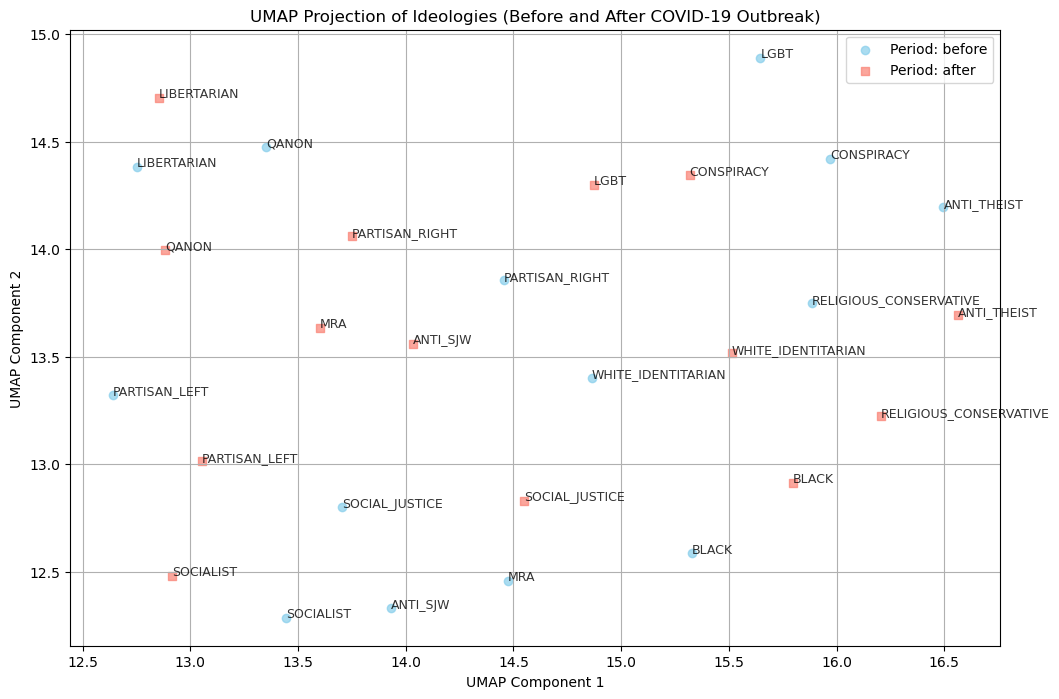

Cosine Similarity between Ideologies Before and After COVID (History only):
ANTI_SJW: 0.6384
ANTI_THEIST: 0.6183
BLACK: 0.8630
CONSPIRACY: 0.7175
LGBT: 0.2445
LIBERTARIAN: 0.7880
MRA: 0.6010
PARTISAN_LEFT: 0.6307
PARTISAN_RIGHT: 0.5221
QANON: 0.7846
RELIGIOUS_CONSERVATIVE: 0.7734
SOCIALIST: 0.7442
SOCIAL_JUSTICE: 0.7772
WHITE_IDENTITARIAN: 0.6251

--------------------------------------------------------------------



In [3]:
# topics = [
#     "Politics", 
#     "Government", 
#     "Community", 
#     "Human Rights", 
#     "Identity", 
#     "Social Justice", 
#     "Culture", 
#     "Human Behavior", 
#     "Education", 
#     "Relationships", 
#     "Personal Growth", 
#     "Society",  
#     "Health",
#     "Economy",
#     "Law Enforcement",
#     "Social Commentary",
#     "Media",
#     "Faith",
#     "Leadership",
#     "History"
# ]

topics = [
    "Politics", 
    "Health",
    "Human Rights",
    "Media",
    "Government", 
    "Community", 
    "Identity", 
    "Social Justice", 
    "Culture", 
    "Human Behavior", 
    "Education", 
    "Relationships", 
    "Personal Growth", 
    "Society",  
    "Economy",
    "Law Enforcement",
    "Social Commentary",
    "Faith",
    "Leadership",
    "History"
]

for t in topics:
    generate_graph(t)